In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import skimage.io as skio
import skimage
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150
import tifffile
import numpy as np
from utils import *
import os
from pathlib import Path
import trackpy as tp
import scipy
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import anderson

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def take_only_walkers_on_fibre_trajectory(in_file, out_file=None):
    """Takes an input file or a stack in the form of TYXC and saves it to out file. Writes the shape of TYX"""  # I changed this to TYXC. My input has a different shape

    if isinstance(in_file, str):
        # Could also be a path object, but that would now fail. pethaps change to file exists, or test if in_file is an array
        stack = skio.imread(in_file)
    else:
        stack = in_file

    dims = stack.shape
    print(dims)
    # skip the channel?
    new_dims = (dims[0], dims[1], dims[2])
    out = np.zeros(new_dims, dtype=np.uint8)
    for i in range(dims[0]):
        frame_fibre = stack[i, :, :, 2]
        frame_walker = stack[i, :, :, 0]
        new = take_only_walkers_on_fibre(frame_fibre, frame_walker)
        out[i] = new

    tifffile.imwrite(
        out_file,
        out,
        ome=True,
        dtype=np.uint8,
        photometric="minisblack",
        metadata={"axes": "TYX"},
    )

In [3]:
# in_file = r"D:\data\2022-04-26_WALKER_DATA\AjasjaRollerData\25C_75mMNaCl_A8fibres\2B9\2B9_SingleMolecule_1nM_A8fibres_25C_75mMNaCl_1.tif"
# in_file = r"D:\data\2022-04-26_WALKER_DATA\AjasjaRollerData\25C_75mMNaCl_A6fibres\2B9\2B9_singlemolecule_1nM_A6fibres_25C_75mMNaCl_1.tif"
# in_file = r"D:\data\2022-04-26_WALKER_DATA\AjasjaRollerData\37C_75mMNaCl_A6fibres\2B9\2B9_singlemolecule_1nM_A6fibres_37C_75mMNaCl_NoMC_4.tif"
# in_file = r"D:\data\2022-04-26_WALKER_DATA\2021-09-27__prelim_data\2B9_SingleMolecule_1nM_A8fibres_25C_75mMNaCl_100-200.tif"
in_file = r'output/20240206-114518_WT_aligned_drift_corrected.tif'

basename = os.path.basename(in_file)
out_dir = Path("./out/")
os.makedirs(out_dir, exist_ok=True)

In [4]:
take_only_walkers_on_fibre_trajectory(in_file, out_dir / basename)
basename_noext, ext = os.path.splitext(basename)

(9714, 174, 173, 3)


In [5]:
fit_method = "lq"
box_side_length = 5
drift = 0
min_gradient = 600

In [6]:
#os.environ['HDF5_DISABLE_VERSION_CHECK']='0'
#TOOD add out parameter
!python -m picasso localize {out_dir/basename} --fit-method {fit_method} --box-side-length {box_side_length}  --gradient {min_gradient} --drift {drift}



    ____  _____________   __________ ____ 
   / __ \/  _/ ____/   | / ___/ ___// __ \
  / /_/ // // /   / /| | \__ \\__ \/ / / /
 / _____/ // /___/ ___ |___/ ___/ / /_/ / 
/_/   /___/\____/_/  |_/____/____/\____/  
                                          
Localize - Parameters:
No       Label           Value     
1        command         localize  
2        files           out\20240206-114518_WT_aligned_drift_corrected.tif
3        box_side_length 5         
4        fit_method      lq        
5        gradient        600       
6        drift           0         
7        roi             None
8        baseline        0         
9        sensitivity     1         
10       gain            1         
11       qe              1         
12       mf              0         
13       pixelsize       130       
14       zc                        
15       suffix                    
16       database        0         
------------------------------------------
Namespace(command='localize', 


LQ fitting: 100%|██████████| 600/600 [00:27<00:00, 21.75task/s] 


In [7]:
# Hack -- for now just rename the out file. This is dangerous in multithreaded environment.
out_locs = out_dir / (basename_noext + "_locs.hdf5")
new_suffix = f"__locs__fit_{fit_method}__box_{box_side_length}__gradient_{min_gradient}__drift_{drift}.hdf5"
new_suffix = (
    f"__locs_{fit_method}_box{box_side_length}_grad{min_gradient}_drift{drift}.hdf5"
)
new_out_locs = out_dir / (basename_noext + new_suffix)
print(new_out_locs)
out_locs.with_suffix(".yaml").rename(new_out_locs.with_suffix(".yaml"))
out_locs.rename(new_out_locs)

out\20240206-114518_WT_aligned_drift_corrected__locs_lq_box5_grad600_drift0.hdf5


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'out\\20240206-114518_WT_aligned_drift_corrected_locs.yaml' -> 'out\\20240206-114518_WT_aligned_drift_corrected__locs_lq_box5_grad600_drift0.yaml'

In [4]:
max_link_displacement_px = 2
min_tray_length = 3

In [3]:
new_out_locs = Path('out/20240206-114518_WT_aligned_drift_corrected__locs_lq_box5_grad600_drift0.hdf5')

In [7]:
locs = pd.read_hdf(new_out_locs, "locs")
locs["mass"] = locs.photons

tray = tp.link(locs, max_link_displacement_px)

# count the length of trajectories
tray_by_particle = tray.groupby(["particle"])
tray["length"] = tray_by_particle["particle"].transform("count")

print("mean drift ", tp.compute_drift(tray).mean())

# Exclude very short trays
tray = tray.query(f"length>={min_tray_length}")

steps = tray.groupby(["particle"]).apply(get_steps_from_df)
steps["step_len"] = np.sqrt(steps.dx**2 + steps.dy**2)

suffix = f"__link{max_link_displacement_px}_traylen{min_tray_length}"
base_linked_tray = Path(f'{new_out_locs.with_suffix("")}{suffix}')
tray_out = base_linked_tray.with_suffix(".tray.csv.gz")
tray.to_csv(tray_out)
steps_out = base_linked_tray.with_suffix(".steps.csv.gz")
steps.to_csv(steps_out)

#distribution_check = []
steps_matrix = steps[['dx', 'dy']].to_numpy()
num_columns = steps_matrix.shape[1]  
normal_str = ''
for var_idx in range(num_columns):
    anderson_data = anderson(steps_matrix[:, var_idx])
    is_normal = anderson_data.statistic < anderson_data.critical_values[1]
    #distribution_check += [is_normal]
    if not is_normal:
        normal = f"variable {f'dx' if var_idx == 0 else f'dy'} NOT normally distributed at {anderson_data.significance_level[1]}%\n"
    else:
        normal = f"variable {f'dx' if var_idx == 0 else f'dy'} normally distributed at {anderson_data.significance_level[1]}%\n"
    normal_str += normal 

info = {}
info["diff_1D_px_px_frame"] = float(get_diff_from_steps(steps))

px_to_nm = 110
frame_to_s = 0.665

info["diff_1D_nm_nm_s"] = (
    info["diff_1D_px_px_frame"] * px_to_nm * px_to_nm / frame_to_s
)
info["time_per_1000nm_s"] = 1000 * 1000 / info["diff_1D_nm_nm_s"] / 2

info["mean_step_nm_s"] = float(
    np.sqrt(2 * info["diff_1D_nm_nm_s"] * frame_to_s) / frame_to_s
)

diff_info_out = base_linked_tray.with_suffix(".diff")

info["normality_str"] = normal_str
info["anderson_test"] = anderson_data

write_yaml(info, diff_info_out)


Frame 9713: 14 trajectories present.
mean drift  y   -23.804871
x    11.581981
dtype: float32


In [8]:
x = steps['dx']
y = steps['dy']
bins = (75, 70)
hist, xedges, yedges = np.histogram2d(x, y, bins=(75,50), density=True)
xcent = (xedges[1:] + xedges[:-1])/2
ycent = (yedges[1:] + yedges[:-1])/2
x_grid, y_grid = np.meshgrid(xcent, ycent)
xy = np.stack((x_grid.ravel(), y_grid.ravel())).T


In [9]:
def gaussian_2d(xy, x0, y0, sigmax, sigmay, sigmaxy):
    if xy.shape[-1] != 2 or len(xy.shape) != 2:
        raise ValueError("XY data should have shape (n, 2).")
    mu = np.array([x0, y0])
    sigma = np.array([[sigmax, sigmaxy], [sigmaxy, sigmay]])
    normalization = (((2 * np.pi) ** 2) * np.abs(np.linalg.det(sigma))) ** (-1 / 2)
    bell = np.exp(-0.5 * np.sum(((xy - mu) @ np.linalg.inv(sigma)) * (xy - mu), axis=1))
    return normalization * bell

In [10]:
initial_guess = [0, 0, 1, 1, 0]
bounds = ([-np.inf, -np.inf, 0, 0, -1], [np.inf, np.inf, np.inf, np.inf, 1])
popt, _ = curve_fit(gaussian_2d, xy, hist.T.ravel(), initial_guess)
print(popt)
mu = [popt[0], popt[1]]
cov_matrix = [[popt[2], popt[4]], [popt[4], popt[3]]]

[ 0.0040011  -0.00702936  0.36511883  0.20776628  0.02043896]


variable dx NOT normally distributed at 10.0%
variable dy NOT normally distributed at 10.0%

the means of multivariate normal distrubution are: mu(dx) = 0.004, mu(dy) = -0.007
the standard deviations of the multivariate normal distribution are: sigma(dx) = 0.365, sigma(dy) = 0.208
the covariance of the multivariate normal distribution is: sigma(dxdy) = 0.020
Diff (in px^2/frame):  0.3689572513103485
Diff (in nm^2/s):  6713.357505045438
time per 1000nm (s):  74.47838129046814
mean step (nm/s): 142.0934512472503


Text(0.5, 0.92, 'Probability density of step sizes - surface plot')

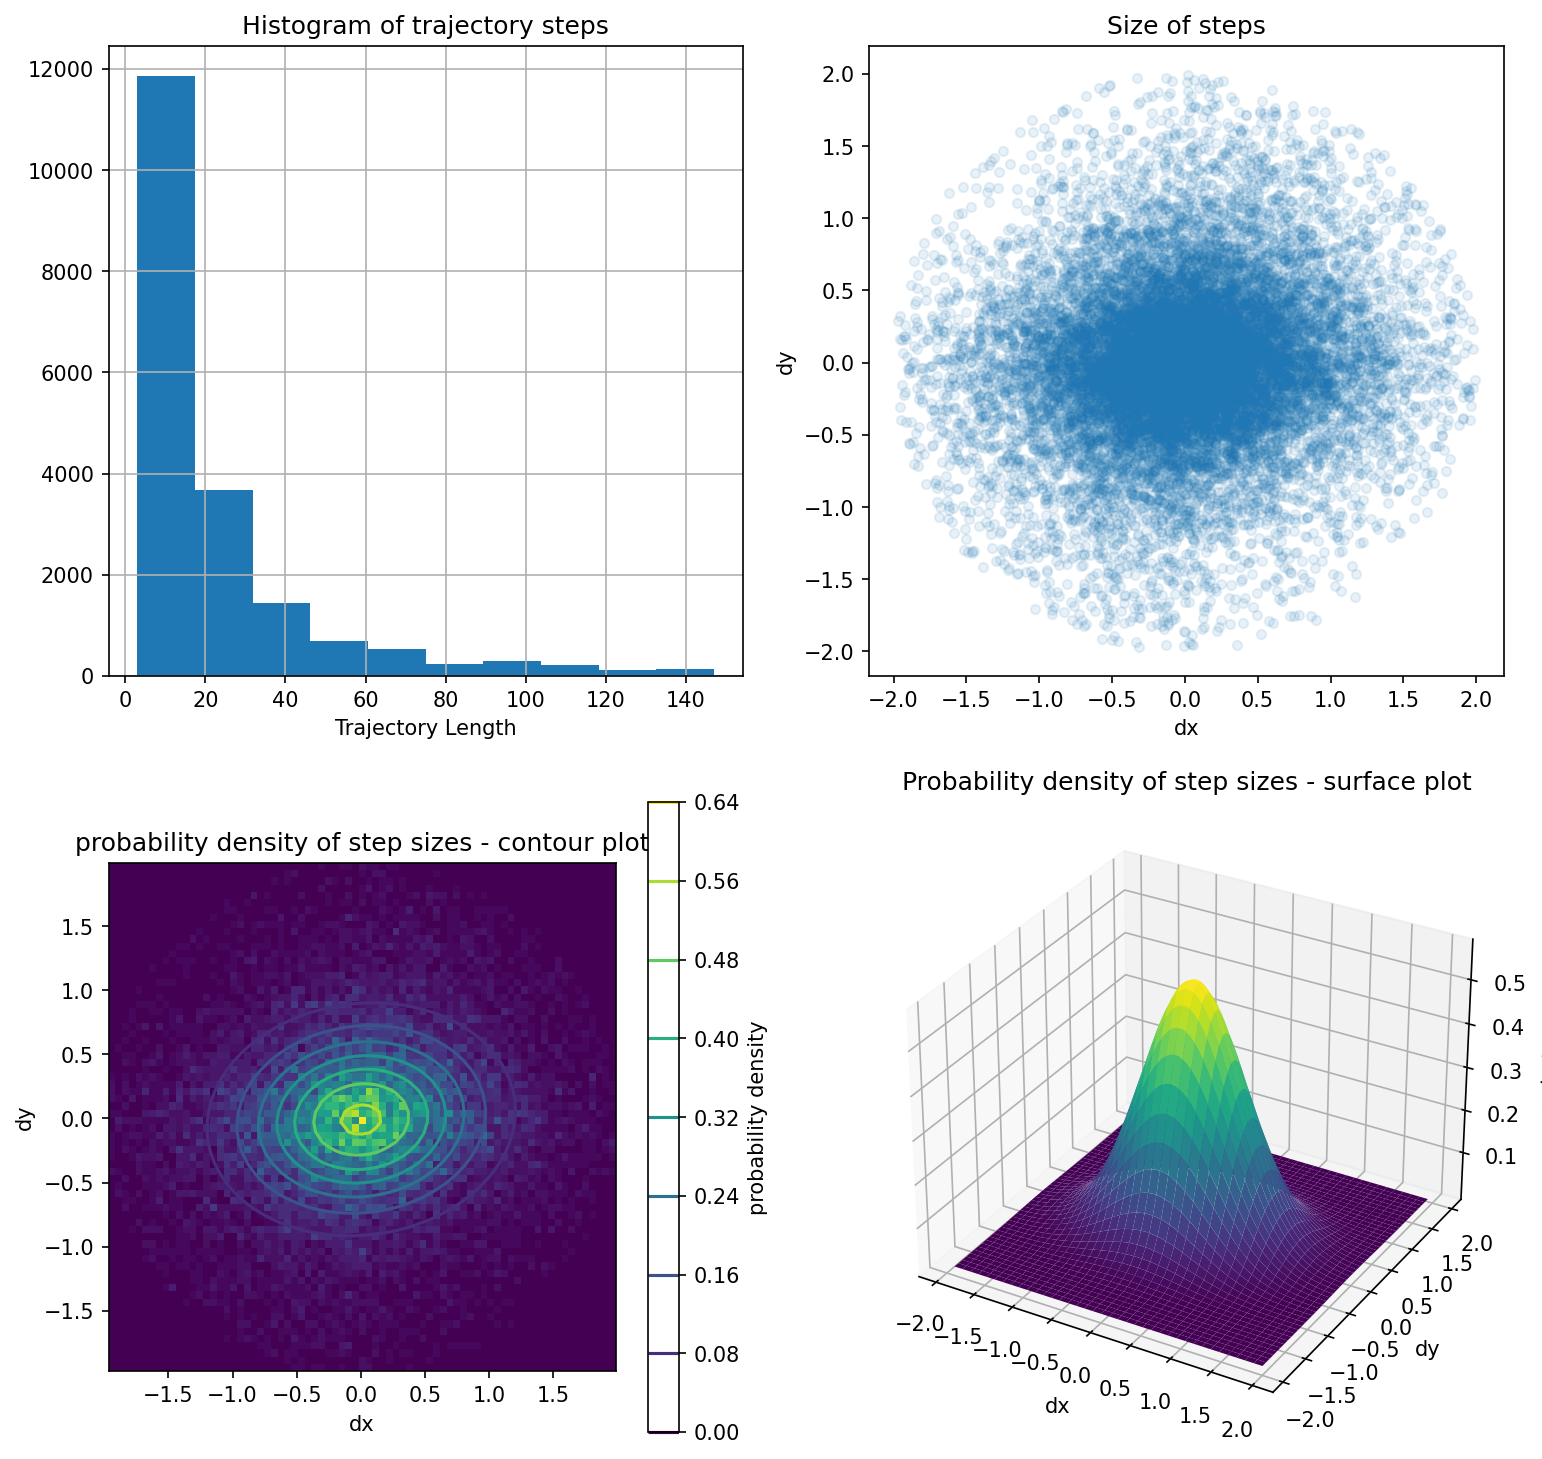

In [12]:
print(normal_str)
print(f'the means of multivariate normal distrubution are: mu(dx) = {mu[0]:.3f}, mu(dy) = {mu[1]:.3f}')
print(f'the standard deviations of the multivariate normal distribution are: sigma(dx) = {cov_matrix[0][0]:.3f}, sigma(dy) = {cov_matrix[1][1]:.3f}')
print(f'the covariance of the multivariate normal distribution is: sigma(dxdy) = {cov_matrix[0][1]:.3f}')
print("Diff (in px^2/frame): ", info["diff_1D_px_px_frame"])
print("Diff (in nm^2/s): ", info["diff_1D_nm_nm_s"])
print("time per 1000nm (s): ", info["time_per_1000nm_s"])
print("mean step (nm/s):", info["mean_step_nm_s"])


z = gaussian_2d(xy, *popt)
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224, projection='3d')
plt.sca(ax1)
tray.length.hist()
plt.xlabel("Trajectory Length")
plt.title("Histogram of trajectory steps")
plt.sca(ax2)
steps.plot.scatter("dx", "dy", alpha=0.1, ax=ax2)
plt.title("Size of steps")
plt.sca(ax3)
plt.hist2d(x,y, bins=bins, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.contour(x_grid, y_grid, z.reshape(x_grid.shape), cmap='viridis')
plt.colorbar(label='probability density')
plt.xlabel('dx')
plt.ylabel('dy')
plt.title('probability density of step sizes - contour plot')
plt.sca(ax4)
ax4.plot_surface(x_grid, y_grid, z.reshape(x_grid.shape), cmap='viridis')
plt.xlabel('dx')
plt.ylabel('dy')
ax4.set_zlabel('probability')
plt.title('Probability density of step sizes - surface plot')
